In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import warnings

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Loading in the data

In [2]:
bee_raw = pd.read_csv('BEETOX RAW DATA AGCOMMONS 1.csv')
bee_raw.head()

,Level of Sociality,Degree of floral specialization,Habitat floral host,bee species,bee genus/species,Date bee captured and installed in bioassay unit (Julian day),bee sex,Imidacloprid concentration (parts per billion),bee longevity in bioassay (days),days paralyzed,days active,% of days bee is paralyzed
0,SOCIAL,POLYLECTIC,HIVE,Apis mellifera,APIS,337.0,F,5.0,10,4,6,40
1,SOCIAL,POLYLECTIC,HIVE,Apis mellifera,APIS,337.0,F,5.0,11,0,11,0
2,SOCIAL,POLYLECTIC,HIVE,Apis mellifera,APIS,337.0,F,5.0,13,1,12,8
3,SOCIAL,POLYLECTIC,HIVE,Apis mellifera,APIS,337.0,F,5.0,13,5,8,38
4,SOCIAL,POLYLECTIC,HIVE,Apis mellifera,APIS,337.0,F,5.0,15,0,15,0


In [3]:
# Displaying the Shape
bee_raw.shape

(725, 12)

# Cleansing and EDA

In [4]:
# Checking for null values
print(bee_raw.isnull().sum())
print(f'\n* Dataframe length before dropping: {len(bee_raw)}')

Level of Sociality                                               1
Degree of floral specialization                                  1
Habitat floral host                                              1
bee species                                                      1
bee genus/species                                                1
Date bee captured and installed in bioassay unit (Julian day)    1
bee sex                                                          1
Imidacloprid concentration (parts per billion)                   1
bee longevity in bioassay (days)                                 1
days paralyzed                                                   1
days active                                                      1
% of days bee is paralyzed                                       1
dtype: int64

* Dataframe length before dropping: 725


In [5]:
# One null field observed in each column, dropping and rechecking the length
bee_raw.dropna(inplace=True)

# Checking for any abnormalities in column names
bee_raw.columns

Index(['Level of Sociality', 'Degree of floral specialization ',
       'Habitat floral host', 'bee species', 'bee genus/species',
       'Date bee captured and installed in bioassay unit (Julian day)',
       'bee sex', 'Imidacloprid concentration (parts per billion)',
       'bee longevity in bioassay (days)', 'days paralyzed', 'days active',
       '% of days bee is paralyzed'],
      dtype='object')

In [6]:
# Removing the trailing space for the following column
bee_raw.rename(columns ={'Degree of floral specialization ': 'Degree of floral specialization'}, inplace=True)

In [7]:
# Checking for any abnormalites within each column
## for col in bee_raw.columns:
##    print(f'{bee_raw[col].value_counts().sort_values(ascending=False)}\n') # Grabbing the unique fields and the occurances

# Summary as the above code loop returns a lengthy output   
## Multiple fields that contain only " . "
## An extra M in the sex column (F, M, M) (Happens to be 'M ' instead of 'M')
## A total of 14 bee species appear 7 or fewer times (highest occurance is 107, Apis mellifera)

Summary as the above code loop returns a lengthy output   
- Multiple fields that contain only " . "
- An extra M is observed in the sex column (F, M, M) (The extra M is 'M ' instead of 'M')
- A total of 14 bee species appear 7 or fewer times (highest occurance is 107, Apis mellifera)

In [8]:
# Correcting the additional Male sex by changing all non 'F' to 'M'
bee_raw.loc[bee_raw['bee sex'] != 'F', 'bee sex'] = 'M'
bee_raw['bee sex'].unique()

array(['F', 'M'], dtype=object)

In [9]:
# Viewing each row that contains a '.'
# bee_raw[(bee_raw == '.').any(axis=1)]
## The above code shows all applicable instances, displaying just the length due to the size

len(bee_raw[(bee_raw == '.').any(axis=1)])

42

In [10]:
# Many of the fields that contained only " . " in some columns had zeros for all numerical columns
# Removing all instances where the bees were not in the study. Assuming 0 days in the bioassay means the bee was not used
no_data = bee_raw[(bee_raw['bee longevity in bioassay (days)'] != '.') & (bee_raw['bee longevity in bioassay (days)'] != '0')]

# Rechecking what remains of the '.' values
no_data[(no_data == '.').any(axis=1)]

,Level of Sociality,Degree of floral specialization,Habitat floral host,bee species,bee genus/species,Date bee captured and installed in bioassay unit (Julian day),bee sex,Imidacloprid concentration (parts per billion),bee longevity in bioassay (days),days paralyzed,days active,% of days bee is paralyzed
147,SOCIAL,POLYLECTIC,SUNFLOWER,Bombus sp,BOMBUS,296.0,F,0.0,1,.,.,.
159,SOCIAL,POLYLECTIC,SUNFLOWER,Bombus sp,BOMBUS,296.0,F,100.0,1,.,.,.
309,SOLITARY,.,OKRA,BEMBIX,BEMBIX,199.0,F,100.0,16,14,2,88
311,SOLITARY,.,SUNFLOWER,BICYRTES,SPHECID,277.0,F,5.0,4,0,4,0
670,SOLITARY,.,SUNFLOWER,T concavus,TRIEPEOLUS,269.0,M,0.0,1,0,1,0
671,SOLITARY,.,SUNFLOWER,T concavus,TRIEPEOLUS,269.0,M,5.0,2,0,2,0
672,SOLITARY,.,SUNFLOWER,T concavus,TRIEPEOLUS,269.0,M,20.0,1,0,1,0
673,SOLITARY,.,SUNFLOWER,T concavus,TRIEPEOLUS,276.0,M,5.0,4,1,3,25


In [11]:
# Rechecking what remains of the '.' values
no_data[(no_data == '.').any(axis=1)]

,Level of Sociality,Degree of floral specialization,Habitat floral host,bee species,bee genus/species,Date bee captured and installed in bioassay unit (Julian day),bee sex,Imidacloprid concentration (parts per billion),bee longevity in bioassay (days),days paralyzed,days active,% of days bee is paralyzed
147,SOCIAL,POLYLECTIC,SUNFLOWER,Bombus sp,BOMBUS,296.0,F,0.0,1,.,.,.
159,SOCIAL,POLYLECTIC,SUNFLOWER,Bombus sp,BOMBUS,296.0,F,100.0,1,.,.,.
309,SOLITARY,.,OKRA,BEMBIX,BEMBIX,199.0,F,100.0,16,14,2,88
311,SOLITARY,.,SUNFLOWER,BICYRTES,SPHECID,277.0,F,5.0,4,0,4,0
670,SOLITARY,.,SUNFLOWER,T concavus,TRIEPEOLUS,269.0,M,0.0,1,0,1,0
671,SOLITARY,.,SUNFLOWER,T concavus,TRIEPEOLUS,269.0,M,5.0,2,0,2,0
672,SOLITARY,.,SUNFLOWER,T concavus,TRIEPEOLUS,269.0,M,20.0,1,0,1,0
673,SOLITARY,.,SUNFLOWER,T concavus,TRIEPEOLUS,276.0,M,5.0,4,1,3,25


In [12]:
# Filling the missing floral specialization with the most frequent category 'OLIGOLECTIC'
no_data.loc[no_data['Degree of floral specialization'] == '.','Degree of floral specialization'] = 'OLIGOLECTIC'

# Not enough information to fill in the effect data (days paralyzed and active), these rows will be removed
# Missing data occurs in the same locations for row so only one column needs to be addressed
no_data = no_data[no_data['days paralyzed'] != '.']
no_data.shape

(688, 12)

In [13]:
species_df = no_data.copy()

# Storing each species and the respective number of occurances
species_count = no_data['bee species'].value_counts()

# This loop will go over each species and isolate those with less than or equal to occurances by name
for spec, ct in species_count.items():
    if ct <= 7:
        # Altering the dataset to exclude the selected species
        species_df = species_df[species_df['bee species']!= spec]          

In [14]:
# Checking data types
species_df.dtypes

Level of Sociality                                                object
Degree of floral specialization                                   object
Habitat floral host                                               object
bee species                                                       object
bee genus/species                                                 object
Date bee captured and installed in bioassay unit (Julian day)    float64
bee sex                                                           object
Imidacloprid concentration (parts per billion)                   float64
bee longevity in bioassay (days)                                  object
days paralyzed                                                    object
days active                                                       object
% of days bee is paralyzed                                        object
dtype: object

In [15]:
# List of columns to adjust data type
change_dtype = ['bee longevity in bioassay (days)', 'days paralyzed', 
                'days active', '% of days bee is paralyzed', 
                'Date bee captured and installed in bioassay unit (Julian day)', 
                'Imidacloprid concentration (parts per billion)']

# Adjusting data types
species_df[change_dtype] = species_df[change_dtype].astype('int64')
species_df.dtypes

Level of Sociality                                               object
Degree of floral specialization                                  object
Habitat floral host                                              object
bee species                                                      object
bee genus/species                                                object
Date bee captured and installed in bioassay unit (Julian day)     int64
bee sex                                                          object
Imidacloprid concentration (parts per billion)                    int64
bee longevity in bioassay (days)                                  int64
days paralyzed                                                    int64
days active                                                       int64
% of days bee is paralyzed                                        int64
dtype: object

In [16]:
# Final shape check
species_df.shape

(655, 12)

# Visualizations

### Histograms

In [17]:
# Storing all object and integer columns to separate variables
cat_cols = species_df.select_dtypes(include=['object']).columns
int_cols = species_df.select_dtypes(include=['int64']).columns

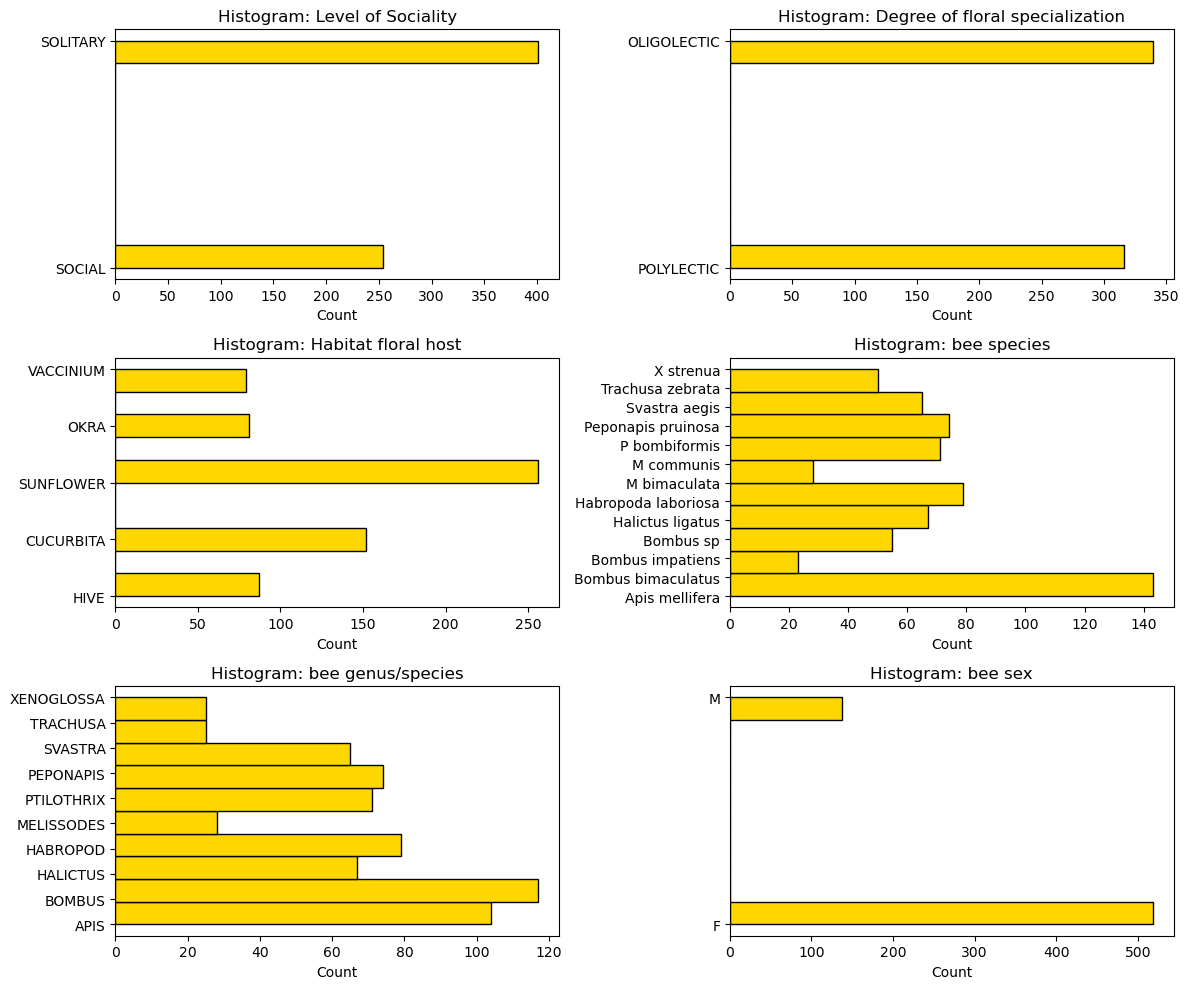

In [18]:
# Setting the starting plot layout (rows, cols, index/plot counter)
cat_params = 321

plt.figure(figsize=(12,10))

for cat_c in cat_cols:
    plt.subplot(cat_params)
    plt.title(f'Histogram: {cat_c}')
    plt.hist(species_df[cat_c], orientation='horizontal', color='gold', edgecolor='black')
    plt.xlabel('Count')
    
    cat_params += 1
    
plt.tight_layout()
plt.show()

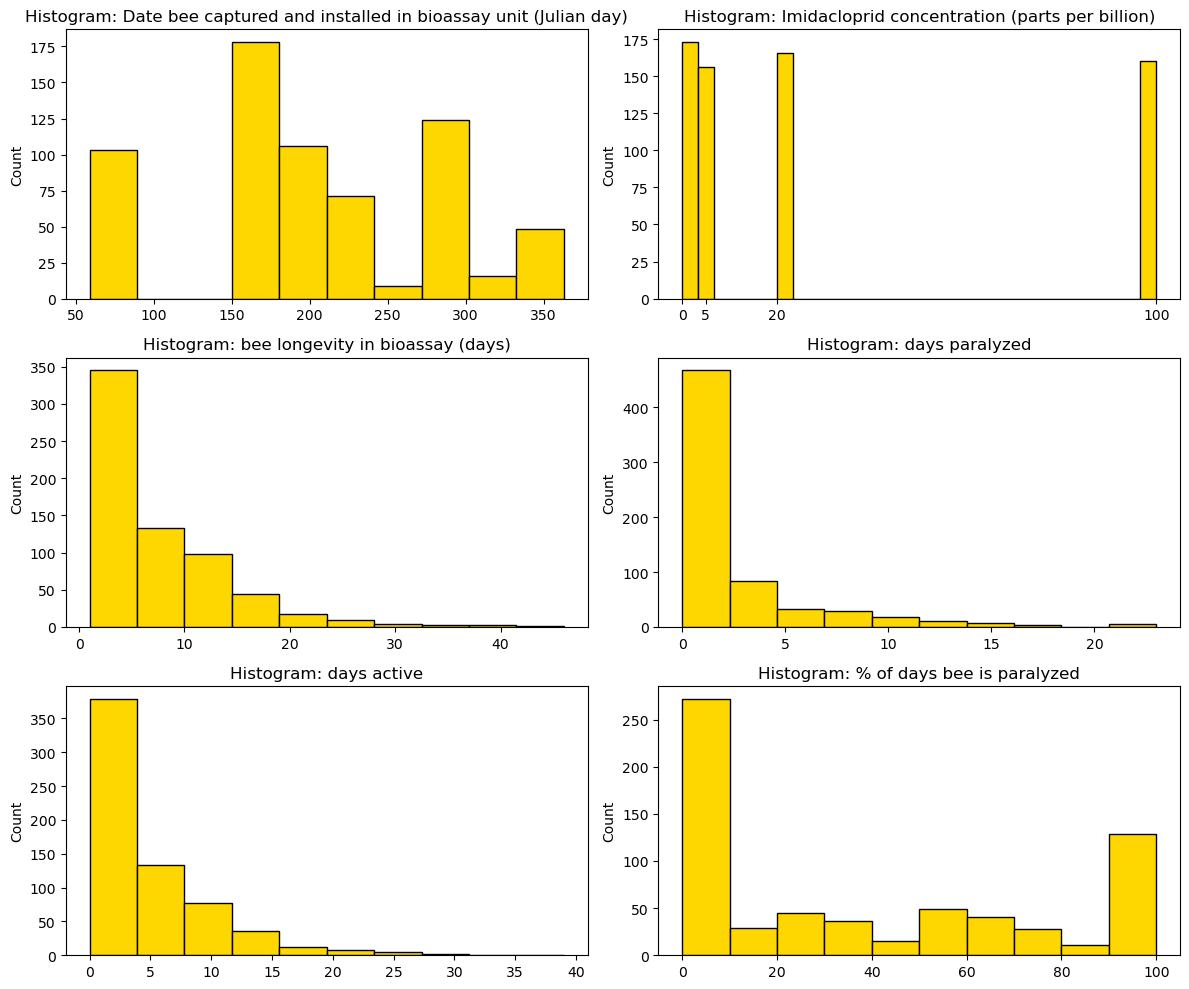

In [19]:
# Setting the starting plot layout (rows, cols, index/plot counter)
int_params = 321
plt.figure(figsize=(12,10))

for int_c in int_cols:
    # Creating a condition to change the x-axis values to better reflect the concentrations
    if int_c == 'Imidacloprid concentration (parts per billion)':
        plt.subplot(int_params)
        plt.title(f'Histogram: {int_c}')
        plt.hist(species_df[int_c], bins=30, color='gold', edgecolor='black')
        plt.xticks([0, 5, 20, 100])
        plt.ylabel('Count')
    else:
        plt.subplot(int_params)
        plt.title(f'Histogram: {int_c}')
        plt.hist(species_df[int_c], color='gold', edgecolor='black')
        plt.ylabel('Count')
    
    int_params += 1
    
plt.tight_layout()
plt.show()

### Scatter Plots

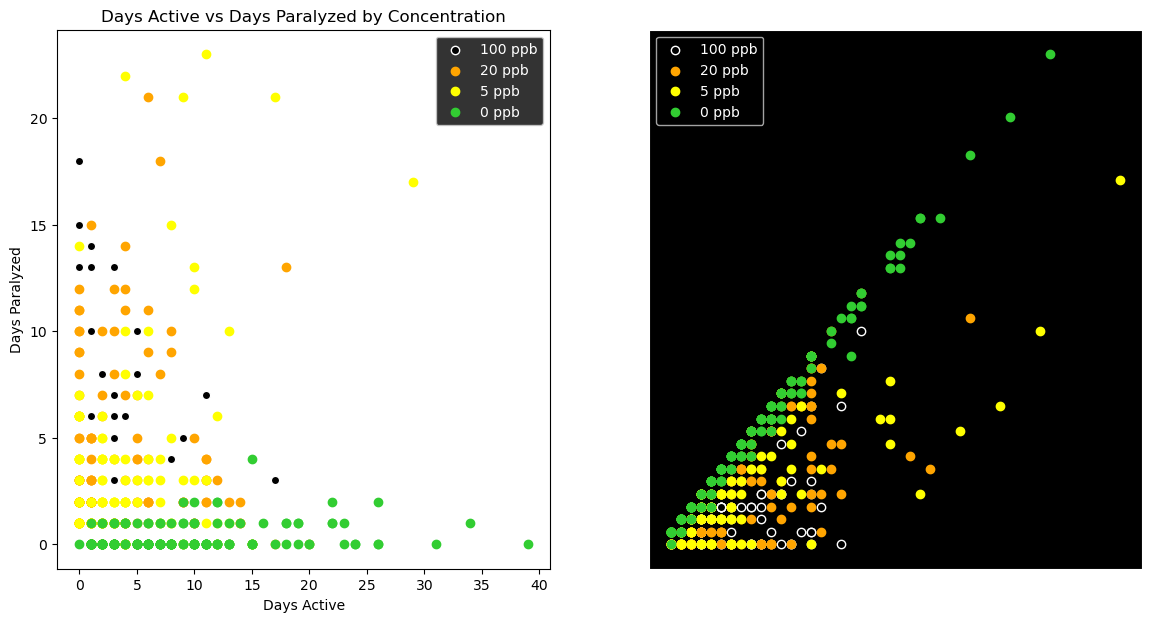

In [20]:
# Separating concentrations
# Creating multiple data frames specific to each concentration
conc_100 = species_df[species_df['Imidacloprid concentration (parts per billion)']==100]
conc_20 = species_df[species_df['Imidacloprid concentration (parts per billion)']==20]
conc_5 = species_df[species_df['Imidacloprid concentration (parts per billion)']==5]
conc_0 = species_df[species_df['Imidacloprid concentration (parts per billion)']==0]

plt.figure(figsize=(14,7))

# Scatter plot for each concentration on Days Active vs Days Paralyzed
plt.subplot(121)
plt.style.use('dark_background')
plt.scatter(conc_100['days active'], conc_100['days paralyzed'], label='100 ppb', 
            color='black', edgecolors='white')
plt.scatter(conc_20['days active'], conc_20['days paralyzed'], label='20 ppb', color='orange')
plt.scatter(conc_5['days active'], conc_5['days paralyzed'], label='5 ppb', color='yellow')
plt.scatter(conc_0['days active'], conc_0['days paralyzed'], label='0 ppb', color='limegreen')

plt.title('Days Active vs Days Paralyzed by Concentration')
plt.xlabel('Days Active')
plt.ylabel('Days Paralyzed')
plt.legend()

# Scatter plot for each concentration on Bee Longevity vs Days Active
plt.subplot(122)
plt.style.use('dark_background')
plt.scatter(conc_100['bee longevity in bioassay (days)'], conc_100['days active'], label='100 ppb', 
            color='black', edgecolors='white')
plt.scatter(conc_20['bee longevity in bioassay (days)'], conc_20['days active'], label='20 ppb', color='orange')
plt.scatter(conc_5['bee longevity in bioassay (days)'], conc_5['days active'], label='5 ppb', color='yellow')
plt.scatter(conc_0['bee longevity in bioassay (days)'], conc_0['days active'], label='0 ppb', color='limegreen')

plt.title('Bee Longevity vs Days Active by Concentration ')
plt.xlabel('Bioassay Longevity (Days)')
plt.ylabel('Days Active')
plt.legend()

plt.show()

### Bar Chart

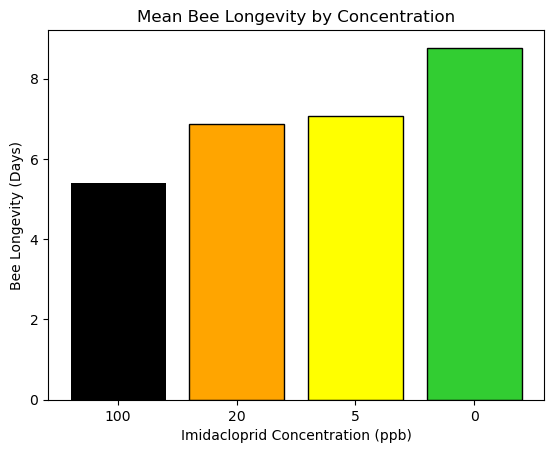

In [21]:
# Bar chart of concentration means vs bee longevity
plt.style.use('default')
plt.bar('100', conc_100['bee longevity in bioassay (days)'].mean(), color= 'black')
plt.bar('20', conc_20['bee longevity in bioassay (days)'].mean(), color='orange', edgecolor='black')
plt.bar('5', conc_5['bee longevity in bioassay (days)'].mean(), color='yellow', edgecolor='black')
plt.bar('0', conc_0['bee longevity in bioassay (days)'].mean(), color='limegreen', edgecolor='black')

plt.title('Mean Bee Longevity by Concentration')
plt.xlabel('Imidacloprid Concentration (ppb)')
plt.ylabel('Bee Longevity (Days)')


plt.show()

### Correlation Heat Map

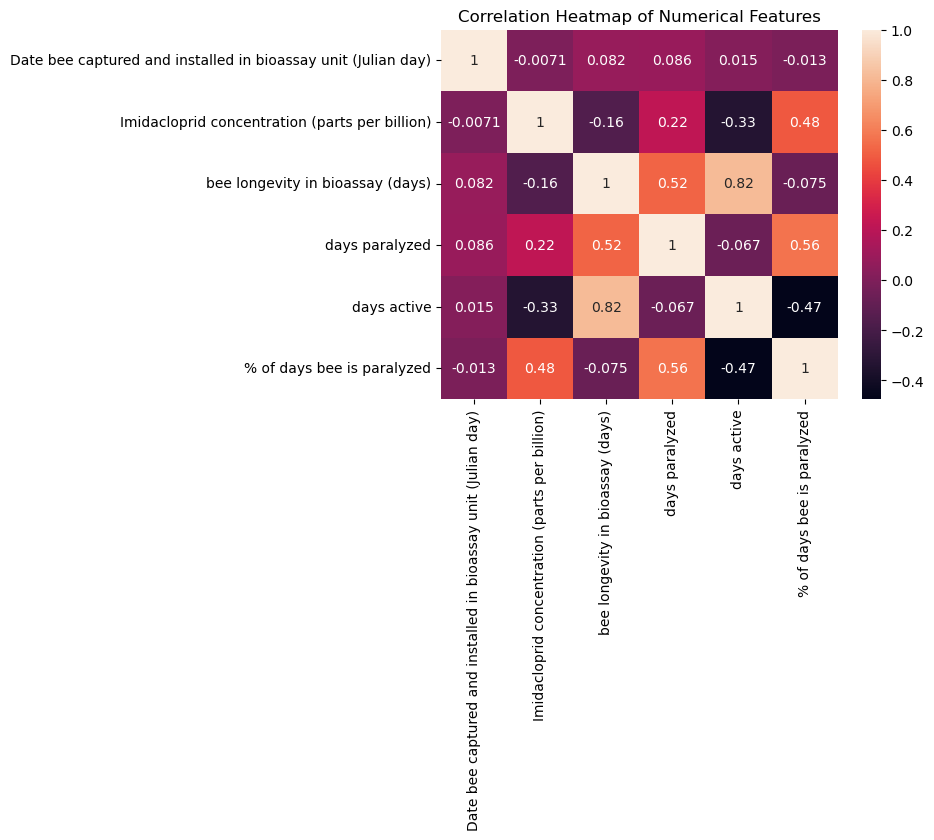

In [22]:
# Correlations
sp_corr = species_df.corr(numeric_only=True)
sns.heatmap(sp_corr, annot=True, linecolor='black')

plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Model Preparation

In [23]:
# Adding to the group of features to drop, These features will be replaced with dummy variables or moved
drop_cols = cat_cols.insert(len(cat_cols), 'Imidacloprid concentration (parts per billion)')
drop_cols

Index(['Level of Sociality', 'Degree of floral specialization',
       'Habitat floral host', 'bee species', 'bee genus/species', 'bee sex',
       'Imidacloprid concentration (parts per billion)'],
      dtype='object')

In [24]:
# Creating dummy variables for the categorical columns
dummy_df = pd.get_dummies(species_df[cat_cols], 
                          prefix=['Sociality Level', 'Floral Specialization', 'Habitat/Floral host', 
                                  'Species', 'Genus/Species', 'Sex'] , drop_first=True)

# Concatinating the dummy and original dataframe back together while dropping the no longer needed features
concat_df = pd.concat([species_df, dummy_df], axis=1).drop(drop_cols, axis=1)
concat_df.head()

,Date bee captured and installed in bioassay unit (Julian day),bee longevity in bioassay (days),days paralyzed,days active,% of days bee is paralyzed,Sociality Level_SOLITARY,Floral Specialization_POLYLECTIC,Habitat/Floral host_HIVE,Habitat/Floral host_OKRA,Habitat/Floral host_SUNFLOWER,...,Genus/Species_BOMBUS,Genus/Species_HABROPOD,Genus/Species_HALICTUS,Genus/Species_MELISSODES,Genus/Species_PEPONAPIS,Genus/Species_PTILOTHRIX,Genus/Species_SVASTRA,Genus/Species_TRACHUSA,Genus/Species_XENOGLOSSA,Sex_M
0,337,10,4,6,40,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,337,11,0,11,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,337,13,1,12,8,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,337,13,5,8,38,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,337,15,0,15,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Removing our target variable
scale_features = int_cols.drop('Imidacloprid concentration (parts per billion)')

# Creating a MinMax Scaler instance
mms = MinMaxScaler()

# Scaling the features
concat_df[scale_features] = mms.fit_transform(concat_df[scale_features])
concat_df.head()

,Date bee captured and installed in bioassay unit (Julian day),bee longevity in bioassay (days),days paralyzed,days active,% of days bee is paralyzed,Sociality Level_SOLITARY,Floral Specialization_POLYLECTIC,Habitat/Floral host_HIVE,Habitat/Floral host_OKRA,Habitat/Floral host_SUNFLOWER,...,Genus/Species_BOMBUS,Genus/Species_HABROPOD,Genus/Species_HALICTUS,Genus/Species_MELISSODES,Genus/Species_PEPONAPIS,Genus/Species_PTILOTHRIX,Genus/Species_SVASTRA,Genus/Species_TRACHUSA,Genus/Species_XENOGLOSSA,Sex_M
0,0.914474,0.200000,0.173913,0.153846,0.40,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.914474,0.222222,0.000000,0.282051,0.00,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.914474,0.266667,0.043478,0.307692,0.08,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.914474,0.266667,0.217391,0.205128,0.38,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.914474,0.311111,0.000000,0.384615,0.00,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Finalizing our target and feature dataframes
target_df = species_df.loc[:, 'Imidacloprid concentration (parts per billion)']
features_df = concat_df.copy()

In [27]:
# Splitting the dataframes for testing and training
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, train_size=0.8, random_state=70)
print(f'- Sizes -\nX_Train {X_train.shape} -- X_Test {X_test.shape}\ny_Train {y_train.shape} -- y_Test {y_test.shape}')

- Sizes -
X_Train (524, 33) -- X_Test (131, 33)
y_Train (524,) -- y_Test (131,)


In [28]:
# Checking the distributions of the target concentrations
print(f'Training Counts\n{y_train.value_counts()}\n\nTest Counts\n{y_test.value_counts()}')

Training Counts
20     138
5      131
100    128
0      127
Name: Imidacloprid concentration (parts per billion), dtype: int64

Test Counts
0      46
100    32
20     28
5      25
Name: Imidacloprid concentration (parts per billion), dtype: int64


# Modeling: Linear SVC

In [29]:
# Creating a dictionary of parameters to test
params = {'tol':[0.00008, 0.00009, 0.0001, 0.00015], 
         'C':[1.3754, 1.373, 1.374, 1.375, 1.376]}

# Creating a Linear SVC
SVC = LinearSVC(random_state=70)

# Initializing the GridSearch CV
gs = GridSearchCV(SVC, params, refit=True, n_jobs=2, verbose=1)

In [30]:
# Hiding warnings regarding parameters that did not work
warnings.simplefilter('ignore', (UserWarning, FutureWarning))

# Fitting the training data
gs_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [31]:
# Making predictions
y_pred = gs_model.predict(X_test)

# Metrics

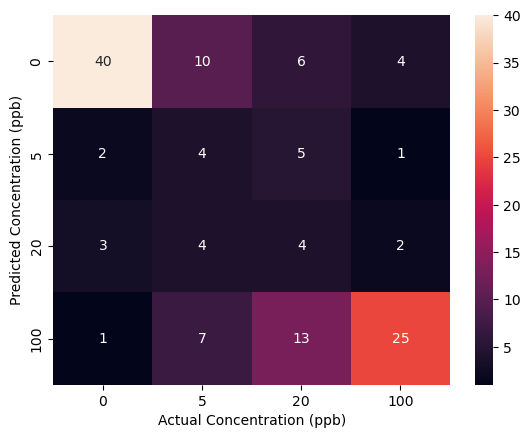

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_pred, y_test)
labels = [0, 5, 20, 100]
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)

plt.xlabel('Actual Concentration (ppb)')
plt.ylabel('Predicted Concentration (ppb)')
plt.show()

In [33]:
# Function responsible for calculating metrics
def metric_calc(predicitions, label):
    accuracy = round(accuracy_score(predicitions, y_test), 3)*100
    precision = round(precision_score(predicitions, y_test, average='weighted'), 3)*100
    recall = round(recall_score(predicitions, y_test, average='weighted'), 3)*100
    f1 = round(f1_score(predicitions, y_test, average='weighted'), 3)*100
    
    print(f'{label} Metrics\n\nAccuracy - {accuracy} %\nPrecision - {precision} %\nRecall - {recall} %\nF1 Score - {f1} %')  

In [34]:
metric_calc(y_pred, 'Linear SVC')

Linear SVC Metrics

Accuracy - 55.7 %
Precision - 70.1 %
Recall - 55.7 %
F1 Score - 61.0 %


## Encoded Target

In [35]:
# Encoding the target, seeing how the metrics are impacted what the target variable having a mean closer to zero
species_df['Concentrations'] = species_df['Imidacloprid concentration (parts per billion)']
species_df['Concentrations'] = species_df['Concentrations'].astype('category')

In [36]:
le = LabelEncoder()

le_conc = le.fit_transform(species_df['Concentrations'])

In [37]:
# Splitting the dataframes for testing and training
X_train, X_test, ysc_train, ysc_test = train_test_split(features_df, le_conc, train_size=0.8, random_state=70)

In [38]:
gs_sc_targ_model = gs.fit(X_train, ysc_train)
sc_targ_pred = gs_sc_targ_model.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [39]:
metric_calc(sc_targ_pred, 'Linear SVC (Encoded Target)')

Linear SVC (Encoded Target) Metrics

Accuracy - 30.5 %
Precision - 39.800000000000004 %
Recall - 30.5 %
F1 Score - 34.599999999999994 %
